In [1]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
plt.style.use('ggplot')

In [3]:
coordinates_df = pd.read_csv('../data/coordinates.csv')
coordinates_df.head(2)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
1,1,1.2,-37.609,5.885,-6.684


In [4]:
def calculate_relative_times(theta_deg, phi_deg, coordinates_df):
    """
    Рассчитывает относительное время срабатывания станций для заданных углов θ и φ.

    Parameters:
    -----------
    theta_deg : float
        Зенитный угол (в градусах).
    phi_deg : float
        Азимутальный угол (в градусах).
    coordinates_df : pd.DataFrame
        Таблица с координатами станций, содержащая столбцы ['X', 'Y', 'Z'].

    Returns:
    --------
    list
        Список вида [(x1, y1, z1, t1), (x2, y2, z2, t2), ...] для всех станций,
        отсортированный по времени срабатывания.
    """
    C = 299792458e-9

    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)

    v = np.array([
        np.sin(theta) * np.cos(phi),
        np.sin(theta) * np.sin(phi),
        np.cos(theta)
    ])

    coordinates_df = coordinates_df.copy()
    coordinates_df["time"] = -(coordinates_df[["X", "Y", "Z"]].values @ v) / C

    coordinates_df["relative_time"] = coordinates_df["time"] - \
        coordinates_df["time"].min()

    sequence = [
        (row.X, row.Y, row.Z, row.relative_time)
        for row in coordinates_df.itertuples()
    ]
    return sequence

In [9]:
def generate_dataset(theta_list, phi_list, coordinates_df):
    dataset = []

    total_iterations = len(theta_list) * len(phi_list)
    with tqdm(total=total_iterations, desc="Generating dataset", unit="iteration") as pbar:
        for theta in theta_list:
            for phi in phi_list:
                sequence = calculate_relative_times(theta, phi, coordinates_df)

                relative_times = [row[3] for row in sequence]

                row_data = relative_times + [theta, phi]
                dataset.append(row_data)

                pbar.update(1)

    column_names = [
        f't_{i+1}' for i in range(len(coordinates_df))] + ['theta', 'phi']

    dataset_df = pd.DataFrame(dataset, columns=column_names)

    return dataset_df

In [124]:
def generate_dataset1(theta, phi, coordinates_df):
    dataset = []

    total_iterations = len(theta)
    with tqdm(total=total_iterations, desc="Generating dataset", unit="iteration") as pbar:
        for i in range(len(theta)):
            sequence = calculate_relative_times(
                theta[i], phi[i], coordinates_df)

            relative_times = [row[3] for row in sequence]

            row_data = relative_times + [theta[i], phi[i]]
            dataset.append(row_data)

            pbar.update(1)

    column_names = [
        f't_{i+1}' for i in range(len(coordinates_df))] + ['theta', 'phi']

    dataset_df = pd.DataFrame(dataset, columns=column_names)

    return dataset_df

In [236]:
phi_list = list(np.arange(182, 270, 0.1)) + list(np.arange(271, 360, 0.1))
theta_list = list(np.arange(1, 89.5, 0.1)) * 2

In [237]:
print(len(phi_list), len(theta_list))

1770 1770


In [238]:
my_dataset = generate_dataset1(theta_list, phi_list, coordinates_df)
my_dataset.head(5)

Generating dataset: 100%|██████████| 1770/1770 [00:15<00:00, 117.08iteration/s]


,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,...,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,theta,phi
0,21.254080,20.541382,20.514564,21.227262,21.317977,20.605278,20.578460,21.291158,0.828115,0.051361,...,53.323589,53.506503,53.475419,51.791695,23.340979,22.765606,22.654190,23.146186,1.0,182.0
1,21.151727,20.367815,20.336841,21.120753,21.225524,20.441613,20.410639,21.194550,0.913687,0.059320,...,53.605581,53.700099,53.664198,52.068918,23.228599,22.584066,22.468309,23.029465,1.1,182.1
2,21.049702,20.194592,20.159194,21.014304,21.134039,20.278929,20.243531,21.098641,0.999757,0.067792,...,53.887279,53.893415,53.852386,52.345540,23.115898,22.402221,22.281841,22.912146,1.2,182.2
3,20.948006,20.021713,19.981624,20.907917,21.043522,20.117228,20.077139,21.003433,1.086324,0.076777,...,54.168679,54.086449,54.039982,52.621560,23.002879,22.220071,22.094790,22.794229,1.3,182.3
4,20.846643,19.849180,19.804132,20.801594,20.953973,19.956511,19.911463,20.908925,1.173386,0.086274,...,54.449778,54.279197,54.226982,52.896973,22.889544,22.037619,21.907157,22.675716,1.4,182.4


In [239]:
X_events = my_dataset.drop(columns=['theta', 'phi']).values
y_events = my_dataset[['theta', 'phi']].values

In [271]:
X_train, X_test, y_train, y_test = train_test_split(
    X_events, y_events, test_size=0.2, random_state=4)

In [272]:
train_data_theta = lgb.Dataset(X_train, label=y_train[:, 0])
train_data_phi = lgb.Dataset(X_train, label=y_train[:, 1])

In [273]:
params = {
    'objective': 'regression',
    'metric': 'l2',
    'num_threads': 10,
}

In [274]:
pbar = tqdm(total=50, desc="Training LightGBM", unit="iteration")


def tqdm_callback(env):
    pbar.update(1)

Training LightGBM: 200iteration [00:28,  7.04iteration/s] ion/s]


In [275]:
clf_theta = lgb.train(params,
                      train_data_theta,
                      num_boost_round=100,
                      valid_sets=[train_data_theta],
                      valid_names=['train'],
                      callbacks=[tqdm_callback])

Training LightGBM:  78%|███████▊  | 39/50 [00:00<00:00, 175.37iteration/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 1416, number of used features: 36
[LightGBM] [Info] Start training from score 44.876766


Training LightGBM: 95iteration [00:00, 225.36iteration/s]                 

In [276]:
clf_phi = lgb.train(params,
                    train_data_phi,
                    num_boost_round=100,
                    valid_sets=[train_data_phi],
                    valid_names=['train'],
                    callbacks=[tqdm_callback])

Training LightGBM: 180iteration [00:00, 341.00iteration/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 1416, number of used features: 36
[LightGBM] [Info] Start training from score 270.693503


c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


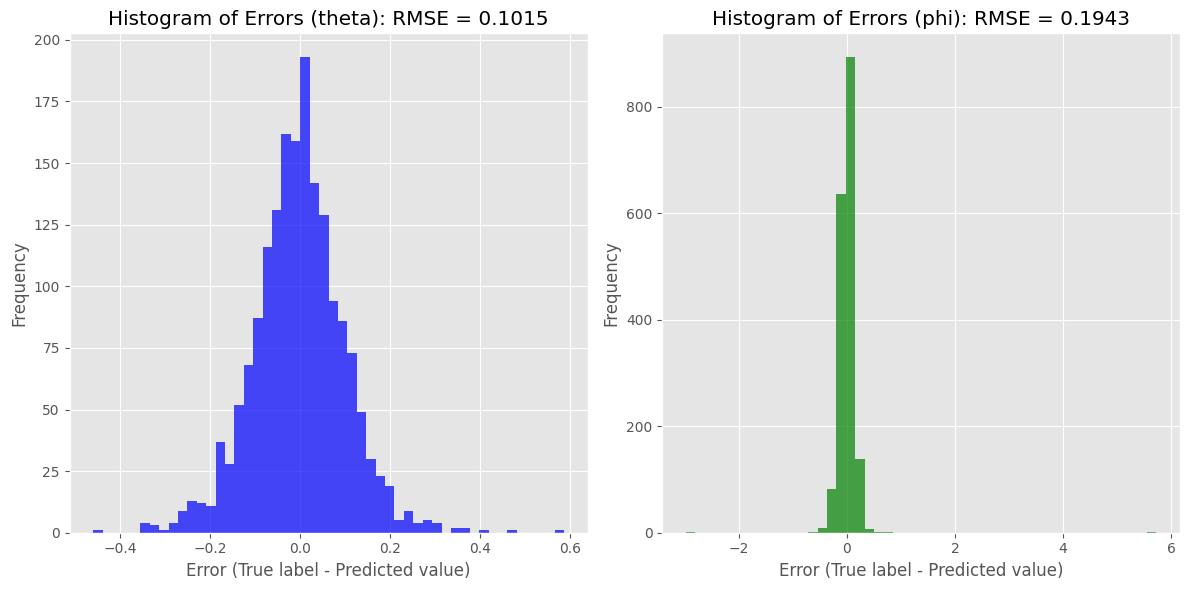

In [277]:
y_pred_theta = clf_theta.predict(
    X_events, num_iteration=clf_theta.best_iteration)
y_pred_phi = clf_phi.predict(X_events, num_iteration=clf_phi.best_iteration)

errors_theta = y_events[:, 0] - y_pred_theta
errors_phi = y_events[:, 1] - y_pred_phi


rmse_theta = mean_squared_error(y_events[:, 0], y_pred_theta, squared=False)
rmse_phi = mean_squared_error(y_events[:, 1], y_pred_phi, squared=False)


y_events_flat_theta = np.ravel(y_events[:, 0])
y_pred_flat_theta = np.ravel(y_pred_theta)

y_events_flat_phi = np.ravel(y_events[:, 1])
y_pred_flat_phi = np.ravel(y_pred_phi)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(errors_theta, bins=50, color='blue', alpha=0.7)
plt.title(f'Histogram of Errors (theta): RMSE = {rmse_theta:.4f}')
plt.xlabel('Error (True label - Predicted value)')
plt.ylabel('Frequency')
plt.grid(True)

# График для phi
plt.subplot(1, 2, 2)
plt.hist(errors_phi, bins=50, color='green', alpha=0.7)
plt.title(f'Histogram of Errors (phi): RMSE = {rmse_phi:.4f}')
plt.xlabel('Error (True label - Predicted value)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

In [278]:
max(errors_phi)

5.729141924285159

c:\Users\matsvei\.ai-navigator\conda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


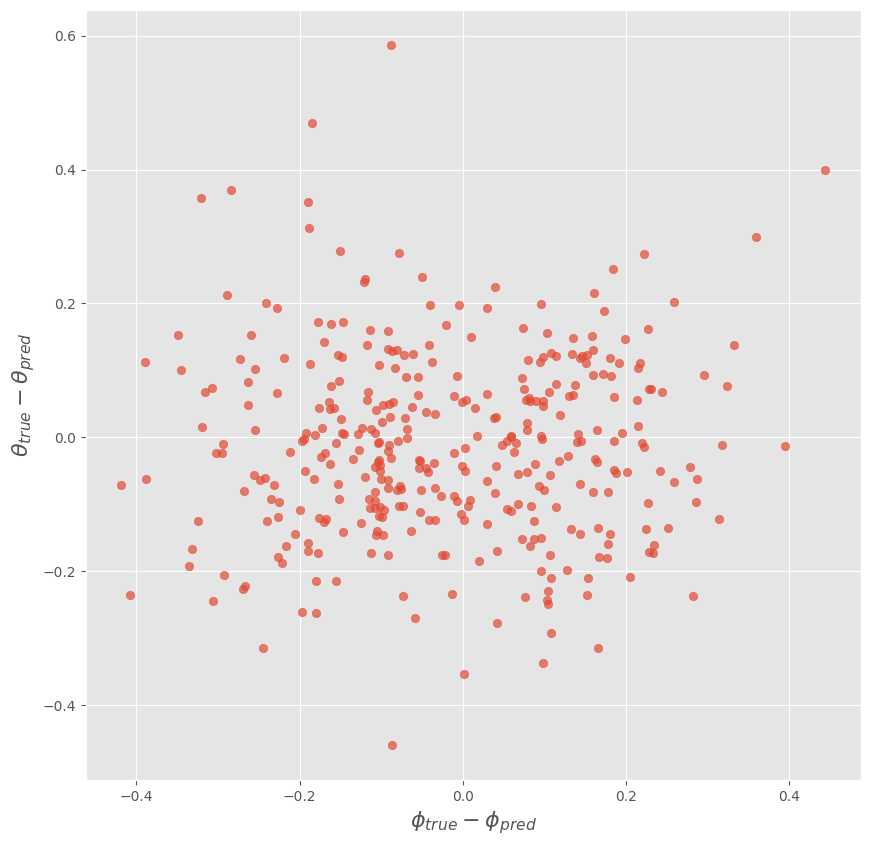

In [291]:
y_pred_theta = clf_theta.predict(
    X_test, num_iteration=clf_theta.best_iteration)

y_pred_phi = clf_phi.predict(
    X_test, num_iteration=clf_phi.best_iteration)

errors_theta = y_test[:, 0] - y_pred_theta
errors_phi = y_test[:, 1] - y_pred_phi

rmse_theta = mean_squared_error(y_test[:, 0], y_pred_theta, squared=False)


y_events_flat_theta = np.ravel(y_events[:, 0])
y_pred_flat_theta = np.ravel(y_pred_theta)

y_events_flat_phi = np.ravel(y_events[:, 1])
y_pred_flat_phi = np.ravel(y_pred_phi)

plt.figure(figsize=(10, 10))

plt.scatter(
    errors_phi,
    errors_theta,
    alpha=0.7,
)
plt.xlabel(r'$\phi_{true} - \phi_{pred}$', fontsize=16)
plt.ylabel(r'$\theta_{true} - \theta_{pred}$', fontsize=16)
# xticks = [0, np.pi/6, np.pi/3, np.pi/2]
# xtick_labels = [
#     r"$0$",
#     r"$\pi/6$",
#     r"$\pi/3$",
#     r"$\pi/2$"
# ]
# plt.xticks(xticks, xtick_labels)
plt.grid(True)
plt.savefig('plots/test_theta_vs_phi_diif.png')
plt.show()

In [ ]:
for i in range(len(y_pred_phi)):
    if abs(y_test[:, 1][i] - y_pred_phi[i]) > 2:
        print(y_test[:, 1][i], y_pred_phi[i])

359.8000000000202 357.7017821952196
274.9000000000009 272.15254380080296
359.9000000000202 357.7017821952196
